In [3]:
from typing import Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from itertools import combinations

In [2]:
def get_state_index(state: int, index: int) -> int:
    """获得一个整数某位置处的二进制值"""
    mask = 1 << index
    return (state & mask) >> index


def flip_state(state: int, index: int) -> int:
    """翻转一个整数某位置处的二进制值"""
    mask = 1 << index
    return state ^ mask

def count_ones(state: int, start: int, end: int) -> int:
    """计算一个整数某一段区间内的二进制值为1的个数"""
    count = 0
    for i in range(start, end+1):
        count += get_state_index(state, i)
    return count

# This is for the free part

In [7]:
L = 4
N = L * L
Nup = 7
state_list = [sum([1 << i for i in c]) for c in combinations(range(N), Nup)]
state_list.sort()

state_dict = {state: idx for idx, state in enumerate(state_list)}

In [8]:
t = 1
Nh = len(state_list)
H_free_up = sp.lil_matrix((Nh, Nh))
for i, state in enumerate(state_list):
    for ns in range(N):
        nr = ns // L
        nc = ns % L
        nsxup = nr * L + np.mod(nc + 1, L)
        nsyup = np.mod(nr + 1, L) * L + nc

        statens = get_state_index(state, ns)
        statensxup = get_state_index(state, nsxup)
        statensyup = get_state_index(state, nsyup)
        if (statens, statensxup) == (1, 0) or (statens, statensxup) == (0, 1):
            stateflip = flip_state(state, ns)  # flip the ns site
            stateflipxup = flip_state(stateflip, nsxup)  # flip the nsxup site

            startid = min(ns, nsxup)
            endid = max(ns, nsxup)
            phase = (-1) ** (count_ones(state, startid, endid) % 2)

            #H_free_up[i, state_list.index(stateflipxup)] += -t * phase
            H_free_up[i, state_dict[stateflipxup]] += -t * phase
        if (statens, statensyup) == (1, 0) or (statens, statensyup) == (0, 1):
            stateflip = flip_state(state, ns)
            stateflipyup = flip_state(stateflip, nsyup)

            startid = min(ns, nsyup)
            endid = max(ns, nsyup)
            phase = (-1) ** (count_ones(state, startid, endid) % 2)

            #H_free_up[i, state_list.index(stateflipyup)] += -t * phase
            H_free_up[i, state_dict[stateflipyup]] += -t * phase
H_free_up = H_free_up.tocsr()

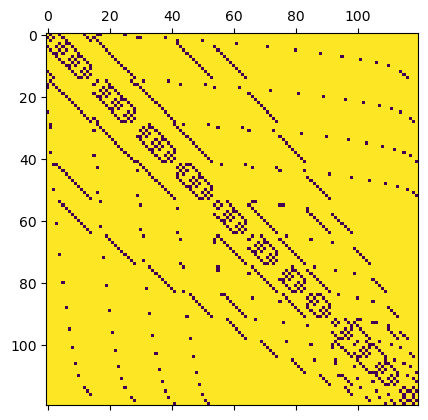

In [80]:
plt.matshow(H_free_up)

In [9]:
# 计算H_free_up的最小特征值
# k=1 表示我们只需要计算最小的一个特征值
# which='SA' 表示找的是特征值中的最小值 (Smallest Algebraic)
eigenvalues, eigenvectors = eigsh(H_free_up, k=1, which='SA')

# 提取最小特征值
min_eigenvalue = eigenvalues[0]

print("最小特征值:", min_eigenvalue)

最小特征值: -12.000000000000005


In [11]:
#eigvals_all = np.linalg.eigvalsh(H_free_up)

In [10]:
#eigvals = eigvals_all[:]
#print(eigvals)

In [18]:
H_classical = np.zeros((N, N))
for ns in range(N):
    nr = ns // L
    nc = ns % L
    nsxup = nr * L + np.mod(nc + 1, L)
    nsyup = np.mod(nr + 1, L) * L + nc
    H_classical[ns, nsxup] -= t
    H_classical[ns, nsyup] -= t
H_classical = H_classical + H_classical.T

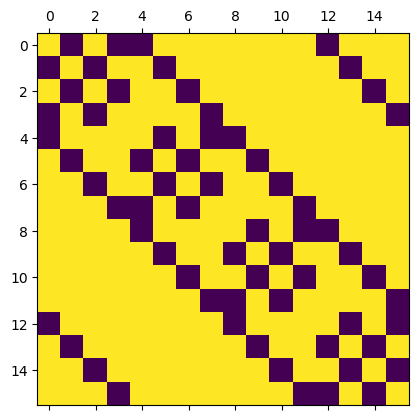

In [19]:
import matplotlib.pyplot as plt
plt.matshow(H_classical)

In [20]:
eig_single = np.linalg.eigvals(H_classical)
eig_single.sort()
eig_single

array([-4.00000000e+00, -2.00000000e+00, -2.00000000e+00, -2.00000000e+00,
       -2.00000000e+00, -2.77863923e-16, -1.97554906e-16, -7.36344679e-17,
       -6.17481140e-17,  4.96303364e-17,  1.25638136e-16,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  4.00000000e+00])

In [124]:
11.868/16

0.74175

In [13]:
H_free = sp.kron(H_free_up, sp.eye(Nh)) + sp.kron(sp.eye(Nh), H_free_up)

# The interaction part

In [14]:
stateaor_list = [bin(state_up & state_down)[2:] for state_up in state_list for state_down in state_list]
count_list = [stateaor.count('1') for stateaor in stateaor_list]
count_array = np.array(count_list)

In [15]:
U = 8 * t
H_int = U * sp.diags(count_array)

In [104]:
3 & 5

1

# Total energy

In [138]:
eigenfree, eigenvecfree = eigsh(H_free, k=1, which='SA')
min_eigenfree = eigenfree[0]

print("ground state energy for the free part:", min_eigenfree)

ground state energy for the free part: -12.000000000000007


In [107]:
-15 + 13*U

89

In [16]:
H = H_free + H_int

In [17]:
eigen, eigenvec = eigsh(H, k=1, which='SA')
min_eigen = eigen[0]

print("ground state energy:", min_eigen)

: 

In [122]:
# Compute the min eigenvalue
eigvals = np.linalg.eigvalsh(H)
eigvals.sort()
eigvals[0]

84.67850286678798

In [123]:
eigvals[0]/L**2

5.292406429174249